In [3]:
# Import-import
import pandas as pd
import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import keras_nlp
import os
import json

2024-11-24 06:32:55.102546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732404775.119665   88674 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732404775.124736   88674 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 06:32:55.144669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ryanfikri/anaconda3/envs/capstone-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not foun

In [4]:
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   IN_COLAB = True
else:
   print("NOT in Colab")
   IN_COLAB = False

NOT in Colab


In [7]:
if IN_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "drive/MyDrive/data"
else:
    data_dir = "data"
os.mkdir(data_dir)

FileExistsError: [Errno 17] File exists: 'data'

In [ ]:
# Download raw dataset
!wget -O {data_dir+"/combined_data.csv"} "https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh"

--2024-11-24 06:35:06--  https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh
Resolving drive.google.com (drive.google.com)... 74.125.68.139, 74.125.68.113, 74.125.68.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download [following]
--2024-11-24 06:35:08--  https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.118.132, 2404:6800:4003:c02::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.118.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31469558 (30M) [application/octet-stream]
Saving to: ‘data/combined_data.csv’

data/combined_data. 100%[===================>]  30.01M  4.

# Step 1: Data cleaning

In [9]:
df = pd.read_csv(data_dir+"/combined_data.csv", index_col=0)

In [10]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Step 1a: Basic cleaning

In [12]:
# Check for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    362
status         0
dtype: int64
Number of duplicate rows: 1969


In [13]:
# Drop rows that contain empty values
df = df.dropna() 

# Drop rows that contain duplicate values in the ‘statement’ column and keep only the first row
df = df.drop_duplicates(subset=['statement'], keep='first')

df.reset_index(drop = True, inplace = True)

In [14]:
# Recheck for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Recheck for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    0
status       0
dtype: int64
Number of duplicate rows: 0


### Step 1b: Deep cleaning

In [15]:
# Change the data type of ‘statement’ and ‘status’ columns to string
df = df.astype({"statement":str, "status":str})

In [16]:
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [17]:
def clean_text(text):
    text = text.lower()
    # remove stopwords
    # for word in stopwords:
    #     if word[0] == "'":
    #         text = re.sub(rf"{word}\b", "", text)
    #     else:
    #         text = re.sub(rf"\b{word}\b", "", text)

    # text = re.sub(r'[!"“’#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', ' ', text) # remove punctuation mark
    # text = re.sub(emoj, ' ', text) # remove emoji
    # text = re.sub(r'\d+', ' ', text) # remove number
    # text = re.sub(r'(.)\1+', r'\1', text) # remove repeated character
    # text = re.sub(r' [a-z] ', ' ', text) # remove single character
    # text = re.sub(r'\s+', ' ', text) # remove multiple spaces
    return text.strip()

In [18]:
# CLEAN!!!
df['statement'] = df['statement'].apply(clean_text)
df = df[df['statement'] != ""]

### Step 1c: Very deep cleaning

In [19]:
# Data distribution analysis of each label
df.status.value_counts()

status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

In [20]:
# Adding word count column for further analysis
df['word_count'] = df['statement'].apply(lambda x: len(x.split()))

In [21]:
# Define bins and labels for word count ranges
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]  # Adjust as needed
labels = ['1-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '+1000']

# Add a column to categorize statements into ranges
df['word_count_range'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=True)

In [22]:
# Count the number of statements in each range
df['word_count_range'].value_counts().sort_index()

word_count_range
1-100       32810
101-200      9571
201-300      4257
301-400      1961
401-500      1029
501-600       544
601-700       314
701-800       192
801-900       120
901-1000       70
+1000         205
Name: count, dtype: int64

In [23]:
# Group by word count range and label, then count occurrences
df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)

/tmp/ipykernel_88674/3797327473.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)


status,Anxiety,Bipolar,Depression,Normal,Personality disorder,Stress,Suicidal
word_count_range,,,,,,,
1-100,1785,947,6843,15758,353,1426,5698
101-200,992,810,4059,278,257,647,2528
201-300,435,372,1996,3,157,124,1170
301-400,194,164,981,0,59,38,525
401-500,95,99,477,0,32,31,295
501-600,43,48,273,0,13,13,154
601-700,26,23,157,0,11,2,95
701-800,15,11,102,0,4,6,54
801-900,17,15,48,0,4,3,33


In [24]:
df_export_candidate = df[(df['word_count'] >= 10) & (df['word_count'] <= 1000)].reset_index(drop=True)
df_export_candidate.status.value_counts()

status
Depression              14687
Suicidal                10328
Normal                   8302
Anxiety                  3332
Bipolar                  2486
Stress                   2263
Personality disorder      877
Name: count, dtype: int64

In [25]:
# Count the number of examples for each label
label_counts = df_export_candidate['status'].value_counts()

# Find the label with the minimum count
min_label = label_counts.idxmin()
min_count = label_counts.min()

print(f"Label with the lowest number of examples: {min_label}")
print(f"Number of examples: {min_count}")

Label with the lowest number of examples: Personality disorder
Number of examples: 877


In [26]:
df_export_candidate = df_export_candidate.sort_values(by='word_count', ascending=False)
df_export_candidate = df_export_candidate.groupby('status').head(min_count)
df_export_candidate.reset_index(drop=True, inplace=True)
df_export_candidate

,statement,status,word_count,word_count_range
0,"okay, i do not even know how to express my fee...",Suicidal,1000,901-1000
1,"honestly, this is my first reddit post. i have...",Suicidal,999,901-1000
2,i have read many posts and have wanted to make...,Suicidal,998,901-1000
3,"well, this is going to be a long read. i have ...",Depression,998,901-1000
4,"first off, i was in there with a guy who staye...",Depression,995,901-1000
...,...,...,...,...
6134,does your avpd come with or co-exist with soci...,Personality disorder,12,1-100
6135,tomorrow is my first day in group therapy wish...,Personality disorder,11,1-100
6136,how many people message you in an average day?...,Personality disorder,11,1-100
6137,who knew omg i'm home. finally a place i bel...,Personality disorder,10,1-100


In [27]:
df_export_candidate.status.value_counts()

status
Suicidal                877
Depression              877
Anxiety                 877
Stress                  877
Bipolar                 877
Personality disorder    877
Normal                  877
Name: count, dtype: int64

In [28]:
df_export_candidate.drop(['word_count', 'word_count_range'], axis=1, inplace=True)

In [29]:
df_export_candidate = df_export_candidate.sample(frac=1).reset_index(drop=True)

In [30]:
# Optional, export the cleaned dataset
df_export_candidate.to_csv(data_dir+'/cleaned_data.csv', index=False)

# Step 2: Create the model

In [33]:
VOCAB_SIZE = 10000
MAX_LENGTH = 500
TRAINING_SPLIT = 0.8
BATCH_SIZE = 32
PADDING_TYPE = 'post'
TRUNC_TYPE = 'post'

In [ ]:
# Run this code if you skip step 1. beware, cleaned dataset is not updated regularly
!wget -O {data_dir+"/cleaned_data.csv"} "https://drive.google.com/uc?export=download&id=1yQ8tt6HF6X_A_P0eYwS3yFC5vxGZYdkY"

sentences = []
labels = []

with open(data_dir+"/cleaned_data.csv", 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile) 
    for row in reader_obj: 
        labels.append(row[1])
        sentences.append(row[0])

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

### Step 2a: Create tf.data.Dataset

In [ ]:
# don't run this code if you skip step 1
dataset = tf.data.Dataset.from_tensor_slices((df_export_candidate["statement"].values, df_export_candidate["status"].values))

I0000 00:00:1732405035.075298   88674 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
train_size = int(len(dataset) * TRAINING_SPLIT)
train_dataset = dataset.take(train_size)    
validation_dataset = dataset.skip(train_size)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

train_statement = train_dataset.map(lambda statement, status: statement)
train_labels = train_dataset.map(lambda statement, status: status)

test_statement = validation_dataset.map(lambda statement, status: statement)
test_labels = validation_dataset.map(lambda statement, status: status)

There are 4911 sentence-label pairs for training.

There are 1228 sentence-label pairs for validation.



### Step 2b: Create tokenizer

In [36]:
# comment this code if there's already vocab output file
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_statement,
    vocabulary_size=VOCAB_SIZE,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file=data_dir+'/mental_vocab_subwords.txt'
)

# Initialize the subword tokenizer
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./'+data_dir+'/mental_vocab_subwords.txt'
)

vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary contains {vocab_size} words\n")

2024-11-24 06:41:18.936202: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary contains 7630 words



2024-11-24 06:42:08.014212: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:324] The empty string is found in the vocabulary, which takes place in the token id space but will never be used in the result. Consider cleaning it from the vocabulary.
2024-11-24 06:42:08.014531: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:336] The empty suffix token is found in the vocabulary, which takes place in token id space but will (almost) never be used in the result. Consider cleaning it from the vocabulary.


### Step 2c: Create label encoder

In [37]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.
    
    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)
    
    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)
   
    return label_encoder

# Create the label encoder
label_encoder = fit_label_encoder(train_labels,test_labels)

print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['Suicidal', 'Stress', 'Personality disorder', 'Normal', 'Depression', 'Bipolar', 'Anxiety']


### Step 2d: Dataset preprocessing

In [38]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), 
                                                  maxlen=MAX_LENGTH, 
                                                  truncating=TRUNC_TYPE, 
                                                  padding=PADDING_TYPE
                                                  )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [39]:
# Preprocess dataset
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)
test_sequences_subword = test_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)

train_labels_encoded = train_labels.map(lambda label: label_encoder(label))
test_labels_encoded = test_labels.map(lambda label: label_encoder(label))

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels_encoded)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels_encoded)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )


print(f"Number of batches in the train dataset: {train_dataset_final.cardinality()}")
print(f"Number of batches in the validation dataset: {test_dataset_final.cardinality()}")

Number of batches in the train dataset: 154
Number of batches in the validation dataset: 39


In [40]:
train_batch = next(train_dataset_final.as_numpy_iterator())
validation_batch = next(test_dataset_final.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 500)
Shape of the validation batch: (32, 500)


2024-11-24 06:42:52.296823: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-24 06:42:52.317708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Step 2e: Architect the model

In [41]:
# Hyperparameters
EMBEDDING_DIM = 64
LSTM1_DIM = 32 
LSTM2_DIM = 8
DENSE_DIM = 64

model = tf.keras.Sequential([ 
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(tokenizer.vocabulary_size(), EMBEDDING_DIM),
    # tf.keras.layers.Conv1D(32, 2, activation='relu'),
    # tf.keras.layers.MaxPooling1D(2),
    # tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.1),
    # tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'] 
) 

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       488,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,775 (1.86 MB)

 Trainable params: 488,775 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Check model compatibility
example_batch = train_dataset_final.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

2024-11-24 06:44:03.771031: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
I0000 00:00:1732405443.773961   90378 service.cc:148] XLA service 0x7fcecc0156c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732405443.774632   90378 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-24 06:44:03.806894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732405443.848358   90378 cuda_dnn.cc:529] Loaded cuDNN version 9

predictions have shape: (32, 7)


2024-11-24 06:44:04.887326: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Step 3: How To Train Your ~~Dragon~~ ML Model

In [44]:
# Callbacks
checkpoint_path = data_dir
checkpoint_model_filepath = checkpoint_path+"/checkpoint.weights.h5"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file, log_file):
        self.epoch_file = epoch_file
        self.log_file = log_file
        self.history = {"epoch": [], "train_loss": [], "train_accuracy": [], 
                        "val_loss": [], "val_accuracy": []}
        
        # Load history and starting epoch if they exist
        if os.path.exists(self.log_file):
            with open(self.log_file, 'r') as f:
                self.history = json.load(f)
        
        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.starting_epoch = int(f.read())
        else:
            # with open(self.epoch_file, 'w') as f:
            #     f.write(str(0))
            self.starting_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.starting_epoch + epoch + 1
        # Save the current epoch
        with open(self.epoch_file, 'w') as f:
            f.write(str(current_epoch + 1))

        # Save logs (loss, accuracy, etc.) for plotting
        self.history["epoch"].append(current_epoch + 1)
        self.history["train_loss"].append(logs.get("loss"))
        self.history["train_accuracy"].append(logs.get("accuracy"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_accuracy"].append(logs.get("val_accuracy"))
        
        # Save history to the log file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)
        
custom_checkpoint_callback = CustomCheckpointCallback(checkpoint_num_epoch_filepath, training_log_filepath)

In [45]:
# run this code to delete checkpoint
try:
    os.remove(checkpoint_model_filepath)
    os.remove(checkpoint_num_epoch_filepath)
    os.remove(training_log_filepath)
    print("Checkpoint deleted successfully")
except FileNotFoundError:
    print("No saved epoch found")

No saved epoch found


In [46]:
# run this code to load from checkpoint
try:
    with open(checkpoint_num_epoch_filepath, 'r') as f:
        start_epoch = int(f.read())
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No saved epoch found. Starting from epoch 0")

# Load saved weights
if start_epoch > 0:
    model.load_weights(checkpoint_model_filepath)
    print(f"Loaded weights from {checkpoint_model_filepath}")

No saved epoch found. Starting from epoch 0


In [47]:
num_of_epoch = 10
history = model.fit(
    train_dataset_final, 
    epochs=num_of_epoch - start_epoch, 
    validation_data=test_dataset_final,
    callbacks=[
        model_checkpoint_callback,
        custom_checkpoint_callback
    ]
    )

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2424 - loss: 1.8969 - val_accuracy: 0.5000 - val_loss: 1.6532
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5508 - loss: 1.5452 - val_accuracy: 0.5782 - val_loss: 1.3048
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6491 - loss: 1.1881 - val_accuracy: 0.6376 - val_loss: 1.0526
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6991 - loss: 0.9454 - val_accuracy: 0.6490 - val_loss: 0.9242
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7313 - loss: 0.8048 - val_accuracy: 0.6637 - val_loss: 0.8535
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7602 - loss: 0.7073 - val_accuracy: 0.6702 - val_loss: 0.8083
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7895 - loss: 0.6303 - val_accuracy: 0.6792 - val_loss: 0.7772
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8162 - loss: 0.5651 - val_accuracy: 0.

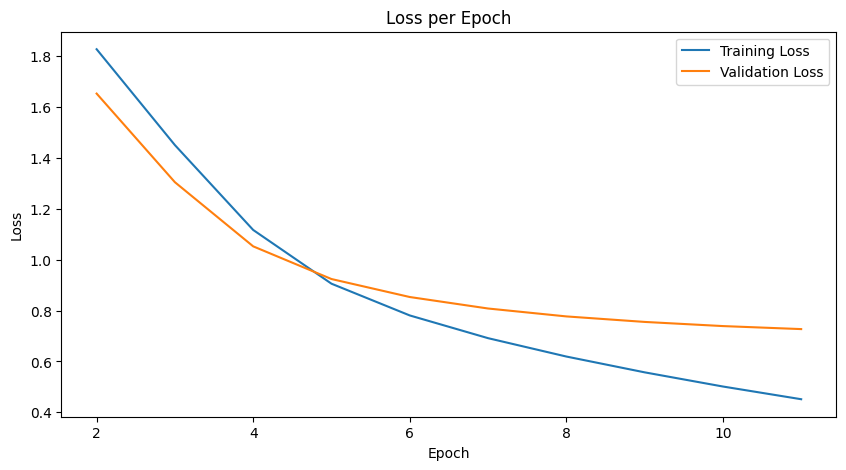

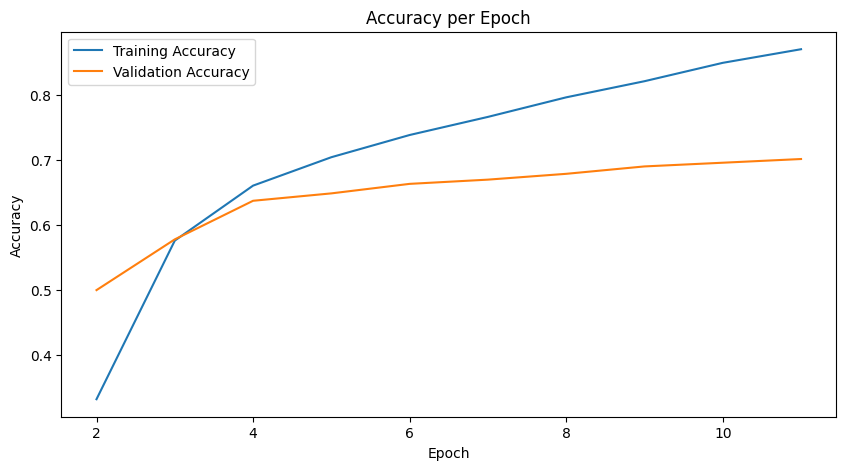

In [48]:
def plot_graphs(training_log):
    # Load the log file
    with open(training_log, "r") as f:
        history = json.load(f)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_loss"], label="Training Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_accuracy"], label="Training Accuracy")
    plt.plot(history["epoch"], history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
plot_graphs(training_log_filepath)

# Step 4: Test the model

In [49]:
rawtext_test = ["i'm really nervous"]
sequence_test = padding_func(tf.data.Dataset.from_tensors(vectorizer.tokenize(rawtext_test)))
for element in sequence_test:
    print(element)
predictions = model.predict(sequence_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(predictions)

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {label_encoder.get_vocabulary()[predicted_class_index]}")

tf.Tensor(
[[  47    8   51  236 1138]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 ...
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]], shape=(500, 5), dtype=int32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
[[4.7185026e-02 2.5185528e-01 2.1679126e-01 ... 1.1565212e-01
  9.7515747e-02 9.2159167e-02]
 [1.6801244e-02 2.8187832e-02 2.2736777e-01 ... 1.1383412e-05
  6.0282834e-03 2.9052503e-03]
 [1.6801244e-02 2.8187832e-02 2.2736777e-01 ... 1.1383412e-05
  6.0282834e-03 2.9052503e-03]
 ...
 [1.6801244e-02 2.8187832e-02 2.2736777e-01 ... 1.1383412e-05
  6.0282834e-03 2.9052503e-03]
 [1.6801244e-02 2.8187832e-02 2.2736777e-01 ... 1.1383412e-05
  6.0282834e-03 2.9052503e-03]
 [1.6801244e-02 2.8187832e-02 2.2736777e-01 ... 1.1383412e-05
  6.0282834e-03 2.9052503e-03]]
Predicted class: Stress


2024-11-24 06:53:06.945163: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Step 5: Done, save the model

In [50]:
# Run this if you happy with the model
with open(data_dir+"/label_vocabulary.txt", "w") as f:
    for label in label_encoder.get_vocabulary():
        f.write(label + "\n")

model.save(data_dir+'/second_iteration.keras')